# Transfer learning and pets

We are going to use transfer learning on pets to transfer weights from a lower number of classes (just terriers) (5) to a larger number of classes (37). 

This builds on the lesson 1 pets found here: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
# Need to set correct GPU
torch.cuda.set_device(1)
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback


In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

If you have gone through lesson1 this should all work

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/home/jd/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2')]

In [7]:
## THIS IS NEW HERE. We want to make a smaller dataset of just terriers.
!mkdir {path}/'images2'
!cp {path}/images/*terrier* {path}/images2/
path_img = path/'images2'
path.ls()

mkdir: cannot create directory ‘/home/jd/.fastai/data/oxford-iiit-pet/images2’: File exists


[PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2')]

In [ ]:
#You should now be seeing the terriers in images2
!ls {path}/'images2'/

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/yorkshire_terrier_103.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/scottish_terrier_113.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/wheaten_terrier_56.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/yorkshire_terrier_80.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images2/scottish_terrier_62.jpg')]

In [10]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

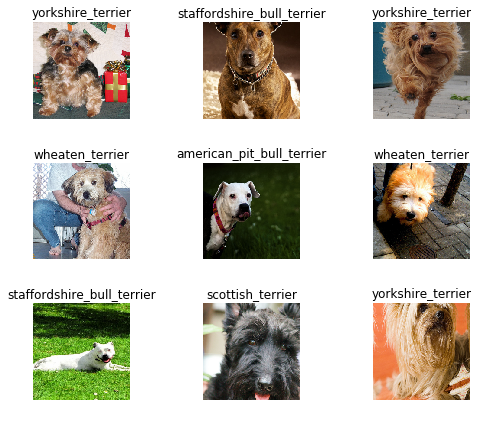

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
# Check our data, you should only see terriers
print(data.classes)
len(data.classes),data.c

['american_pit_bull_terrier', 'scottish_terrier', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(5, 5)

## Training: resnet34 on the terriers
We are going to load and train the terriers

In [14]:
learn = cnn_learner(data,
                    models.resnet34,
                   metrics=[accuracy,error_rate]
                    ,callback_fns=[ShowGraph]
                   ).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03


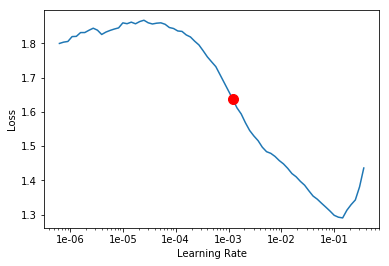

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.755790,1.259252,0.515152,0.484848,00:07
1,1.588790,0.687022,0.823232,0.176768,00:07
2,1.343822,0.331567,0.909091,0.090909,00:07
3,1.199209,0.233921,0.914141,0.085859,00:07
4,1.075434,0.222866,0.934343,0.065657,00:07
5,0.995536,0.242284,0.939394,0.060606,00:07
6,0.933434,0.258292,0.929293,0.070707,00:07
7,0.881437,0.245476,0.944444,0.055556,00:07
8,0.847834,0.250839,0.924242,0.075758,00:07
9,0.816597,0.249383,0.929293,0.070707,00:07


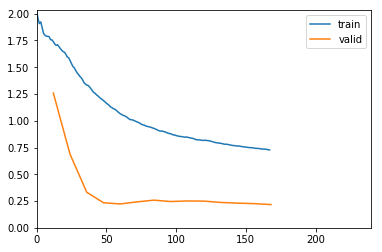

Better model found at epoch 0 with accuracy value: 0.5151515007019043.
Better model found at epoch 1 with accuracy value: 0.8232323527336121.
Better model found at epoch 2 with accuracy value: 0.9090909361839294.
Better model found at epoch 3 with accuracy value: 0.9141414165496826.
Better model found at epoch 4 with accuracy value: 0.9343434572219849.
Better model found at epoch 5 with accuracy value: 0.939393937587738.
Better model found at epoch 7 with accuracy value: 0.9444444179534912.
Better model found at epoch 10 with accuracy value: 0.9494949579238892.
Epoch 13: early stopping


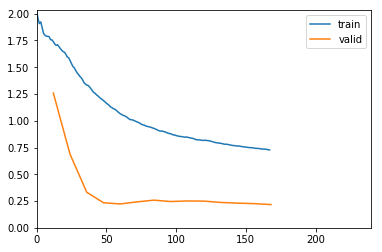

In [16]:
learn.fit_one_cycle(20, 1e-03, 
 callbacks=[EarlyStoppingCallback(learn,monitor='accuracy', min_delta=0.001, patience=2),
            SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestdog')
           ], wd=0.1)

In [ ]:
learn.load('bestdog')

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05


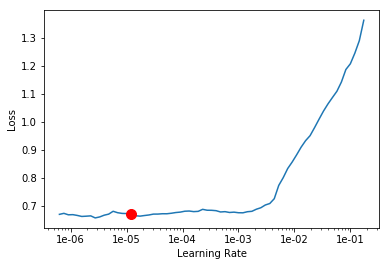

In [19]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.695793,0.236492,0.949495,0.050505,00:07
1,0.683987,0.238972,0.944444,0.055556,00:07
2,0.672598,0.239131,0.939394,0.060606,00:07
3,0.678268,0.237560,0.934343,0.065657,00:07
4,0.681891,0.235123,0.934343,0.065657,00:07
5,0.680504,0.237463,0.939394,0.060606,00:07


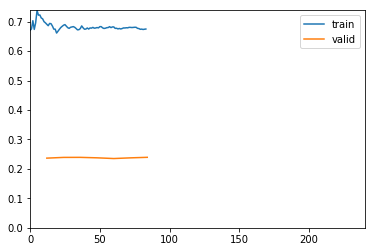

Better model found at epoch 0 with accuracy value: 0.9494949579238892.
Epoch 6: early stopping


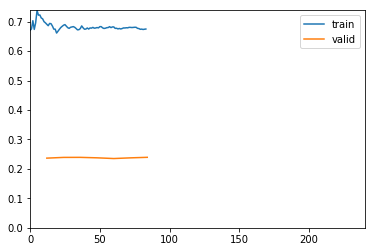

In [20]:
learn.fit_one_cycle(20, max_lr=slice(5e-05,1e-06), 
 callbacks=[EarlyStoppingCallback(learn,monitor='accuracy', min_delta=0.001, patience=5),
            SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestdog')
           ], wd=0.1)

## Results

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

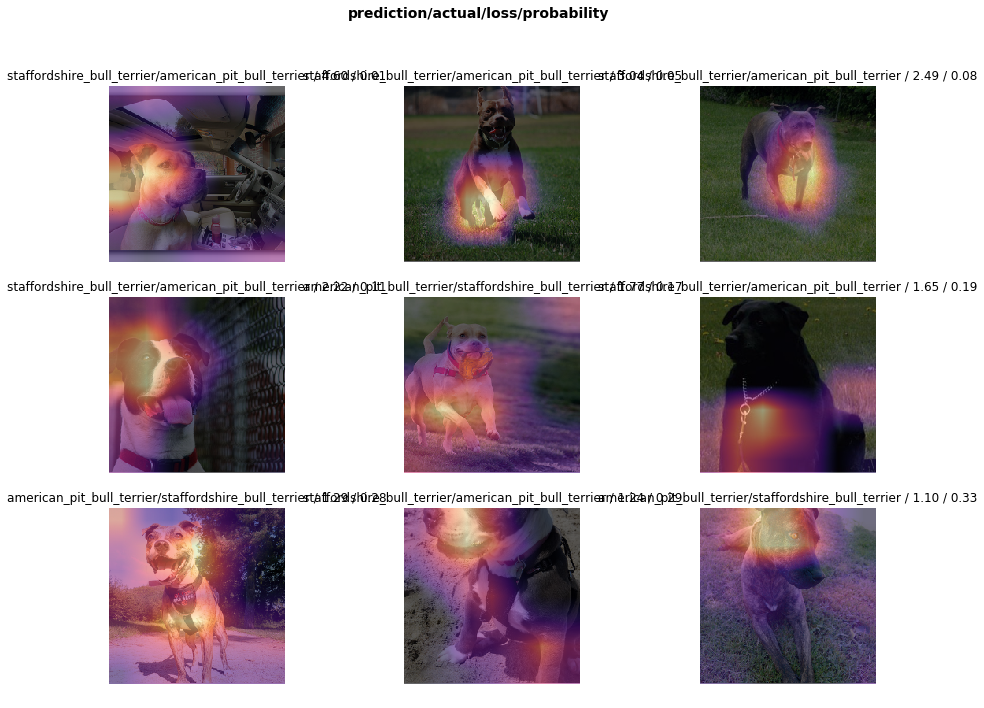

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

In [23]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

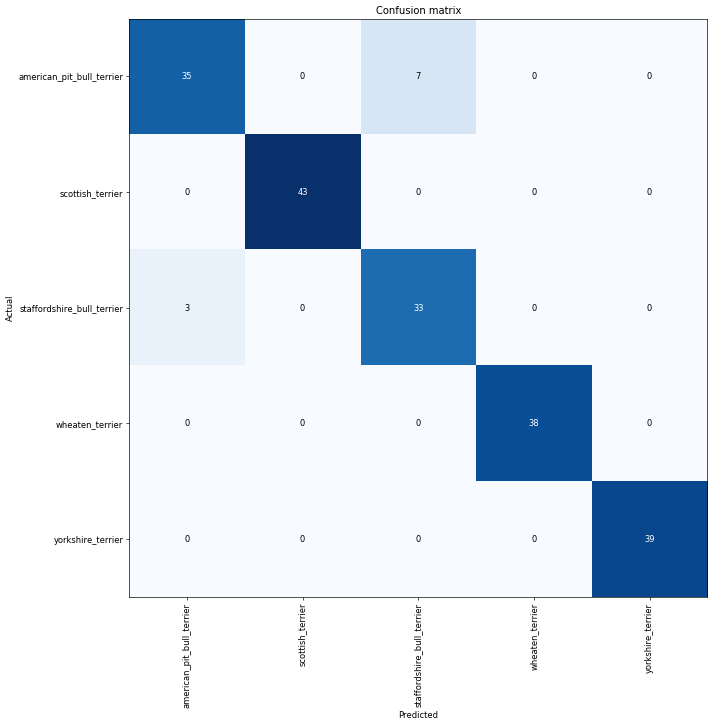

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Transfer Time
Now that we have weights for the 5 terriers we want to use those for the 37 classes in Cats and Dogs. Notice line 9  in Summary below. This is what we are changing.
![Recent](https://i.imgur.com/udulLUx.png)

In [ ]:
learn.summary

In [26]:
# Load old weights
learn.load('bestdog')
# Change classes to the new number of classes; there might be a more clever way; however, I know there are 37
newNumberOfClasses=37
# Replace Linear layer output with 37
learn.model[-1][-1]=nn.Linear(in_features=512,out_features=newNumberOfClasses, bias=True)
# Save the new weights
learn.save('NewModel')

### Start loading the new model. Or the full cats and dogs

In [27]:
path_anno = path/'annotations'
path_img = path/'images'

In [28]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_102.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/newfoundland_145.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/basset_hound_174.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/chihuahua_11.jpg'),
 PosixPath('/home/jd/.fastai/data/oxford-iiit-pet/images/Bengal_128.jpg')]

In [29]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [30]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [31]:
learn = cnn_learner(data,
                    models.resnet34,
                   metrics=[error_rate,accuracy]
                    ,callback_fns=[ShowGraph]
                   ).mixup()

In [ ]:
# Note we are using the old path to images2
learn.load(str(path)+'/images2/models/NewModel')

## Does it run?

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.111790,0.451625,0.106225,0.893775,00:48
1,1.500634,0.337072,0.090663,0.909337,00:49
2,1.348432,0.319120,0.086604,0.913396,00:49
3,1.274269,0.314402,0.081867,0.918133,00:50


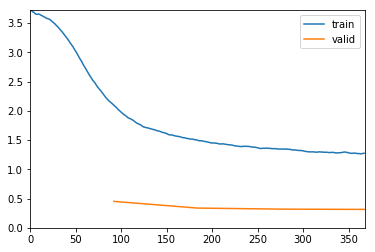

In [33]:
learn.fit_one_cycle(4)

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

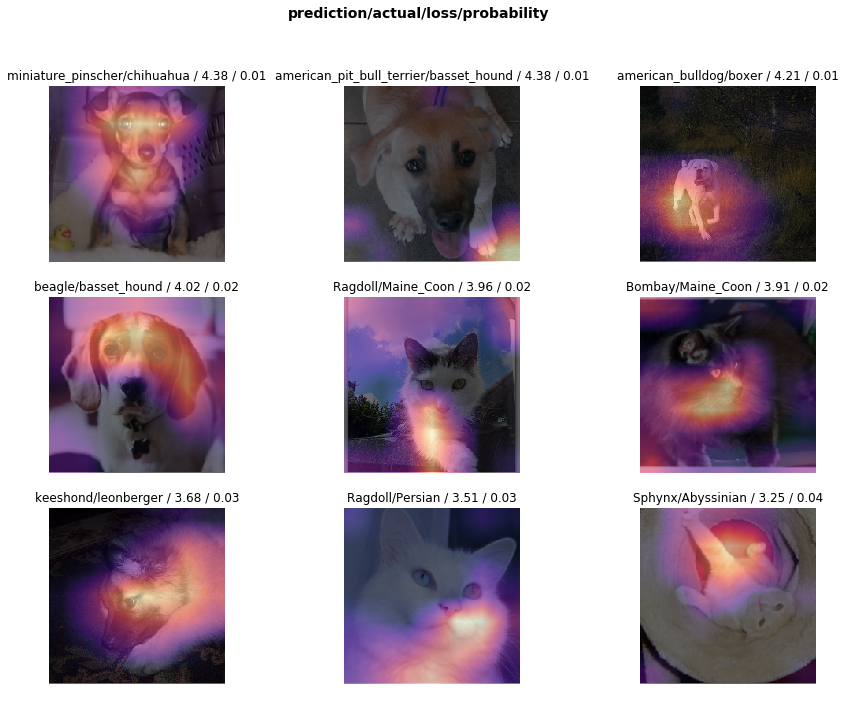

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

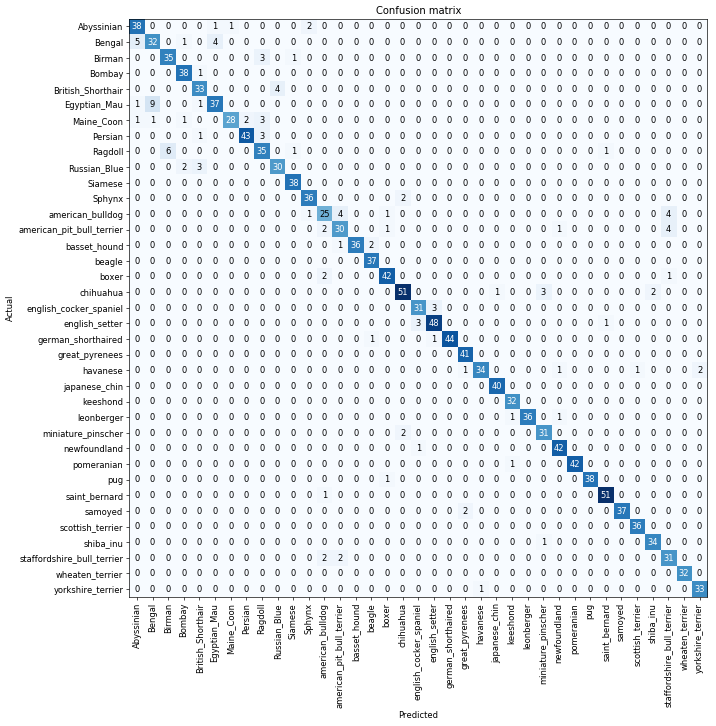

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [39]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 9),
 ('Ragdoll', 'Birman', 6),
 ('Bengal', 'Abyssinian', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Birman', 'Ragdoll', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Persian', 'Ragdoll', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('english_setter', 'english_cocker_spaniel', 3),
 ('Abyssinian', 'Sphynx', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('basset_hound', 'beagle', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'shiba_inu', 2),
 ('havanese', 'yorkshire_terrier', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('samoyed', 'great_pyrenees', 2),

## Compare with Lesson 1
While we could compare both start and the end. Pets 1 isn't really tweaked crazy good. So just looking at the first 4 iterations.

First four cycles look like this: With .10 going down to .07

![Recent](https://i.imgur.com/pJfx2Ma.png)

Pre-train on Terriers allow us to start with: .1 going down to .08
![Recent](https://i.imgur.com/6bJkGNo.png)


Does this help train a model faster? Was the dataset just too small? Don't know. But it looks like it is at least similar to Imagenet.